In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from matplotlib import pyplot as plt
from performance_anomaly_detection.data_preprocessing.time_series_preprocessing import *
from performance_anomaly_detection.training.time_series_training import train_scikit, train_nn, prepare_data_for_training_last_n_fold
from performance_anomaly_detection.anomaly_detection.detector import GaussianTailDetector, AccumulativeDetector, DiffType
from performance_anomaly_detection.training.nns import create_filter_net, create_rnn_net


### 1. Data Read

In [2]:
data_span = pd.read_csv("../data_preprocessing/data_based_on_spans/data_50_100_250.csv", sep=",")
data_span = data_span.loc[data_span.operation_name.str.contains("Currenc")]
data_span = data_span.sort_values(by="start_time")


In [3]:
data_metrics = pd.read_csv("../data_preprocessing/data_based_on_metrics/data_50_100_250.csv", sep=",")


In [4]:
data_traces = pd.read_csv("../data_preprocessing/data_based_on_traces/data_50_100_250.csv", sep=",")

In [5]:
data_metrics.head()

,step,Recv.,Recv.ProductCatalogService.ListProducts,Recv._healthz,Recv.grpc.health.v1.Health.Check,Recv.setCurrency,Sent.AdService.GetAds,Sent.CartService.GetCart,Sent.CurrencyService.Convert,Sent.CurrencyService.GetSupportedCurrencies,...,receive_packets,receive_packets_dropped,transmit_packets,transmit_packets_dropped,receive_bytes,transmit_errors,container_memory_usage_bytes_value,container_memory_working_set_bytes_value,container_cpu_system_seconds_total_value,container_cpu_usage_seconds_total_value
0,1.0,187712.200000,3049.800000,117.0,116.00,1987.440000,19.880000,125451.560000,4953.640000,3938.960000,...,596.0,0.0,527.0,0.0,68746.0,0.0,0.0,0.0,0.0,0.0
1,2.0,90697.533333,5797.533333,140.5,189.50,619.000000,20.800000,30781.066667,4112.314815,9107.700000,...,638.0,0.0,572.0,0.0,73626.0,0.0,0.0,0.0,0.0,0.0
2,3.0,68756.608696,3160.739130,141.0,286.75,4617.826087,19.739130,7989.869565,2997.033816,8289.739130,...,600.0,0.0,534.0,0.0,67744.0,0.0,0.0,0.0,0.0,0.0
3,4.0,156149.000000,1694.130435,27036.5,222.00,3027.260870,25.695652,84646.739130,5889.487923,4569.347826,...,475.0,0.0,424.0,0.0,56847.0,0.0,0.0,0.0,0.0,0.0
4,5.0,117895.960000,4830.800000,119.0,203.00,445.880000,51.480000,53165.160000,5338.253333,1677.360000,...,573.0,0.0,527.0,0.0,66680.0,0.0,0.0,0.0,0.0,0.0


In [6]:
data_span.head()

,operation_name,duration,start_time,step,time,receive_packets,receive_packets_dropped,transmit_packets,transmit_packets_dropped,receive_bytes,transmit_errors,container_memory_usage_bytes_value,container_memory_working_set_bytes_value,container_cpu_system_seconds_total_value,container_cpu_usage_seconds_total_value
0,Recv.setCurrency,812,4722467230915,1.0,4722480677000,596.0,0.0,527.0,0.0,68746.0,0.0,0.0,0.0,0.0,0.0
2,Sent.CurrencyService.GetSupportedCurrencies,1605,4722467237116,1.0,4722480677000,596.0,0.0,527.0,0.0,68746.0,0.0,0.0,0.0,0.0,0.0
6,Sent.CurrencyService.Convert,46618,4722467242143,1.0,4722480677000,596.0,0.0,527.0,0.0,68746.0,0.0,0.0,0.0,0.0,0.0
7,Sent.CurrencyService.Convert,1072,4722467288804,1.0,4722480677000,596.0,0.0,527.0,0.0,68746.0,0.0,0.0,0.0,0.0,0.0
8,Sent.CurrencyService.Convert,5034,4722467289896,1.0,4722480677000,596.0,0.0,527.0,0.0,68746.0,0.0,0.0,0.0,0.0,0.0


In [7]:
data_traces.head()

,trace_id,Recv.,Recv.ProductCatalogService.ListProducts,Recv._healthz,Recv.grpc.health.v1.Health.Check,Recv.setCurrency,Sent.AdService.GetAds,Sent.CartService.GetCart,Sent.CurrencyService.Convert,Sent.CurrencyService.GetSupportedCurrencies,...,receive_packets_dropped,transmit_packets,transmit_packets_dropped,receive_bytes,transmit_errors,container_memory_usage_bytes_value,container_memory_working_set_bytes_value,container_cpu_system_seconds_total_value,container_cpu_usage_seconds_total_value,trace_duration
0,1,0.0,0.0,0.0,234.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,546.0,0.0,73733.0,0.0,0.0,0.0,0.0,0.0,234
1,948,69319.0,597.0,0.0,0.0,0.0,15.0,57988.0,794.666667,1314.0,...,0.0,546.0,0.0,73733.0,0.0,0.0,0.0,0.0,0.0,69319
2,1569,896627.0,558.0,0.0,0.0,0.0,13.0,799116.0,10485.888889,990.0,...,0.0,546.0,0.0,73733.0,0.0,0.0,0.0,0.0,0.0,896627
3,1853,0.0,0.0,0.0,0.0,161.0,0.0,0.0,0.000000,0.0,...,0.0,546.0,0.0,73733.0,0.0,0.0,0.0,0.0,0.0,161
4,2111,49279.0,500.0,0.0,0.0,0.0,12.0,2616.0,4744.888889,1553.0,...,0.0,546.0,0.0,73733.0,0.0,0.0,0.0,0.0,0.0,49279


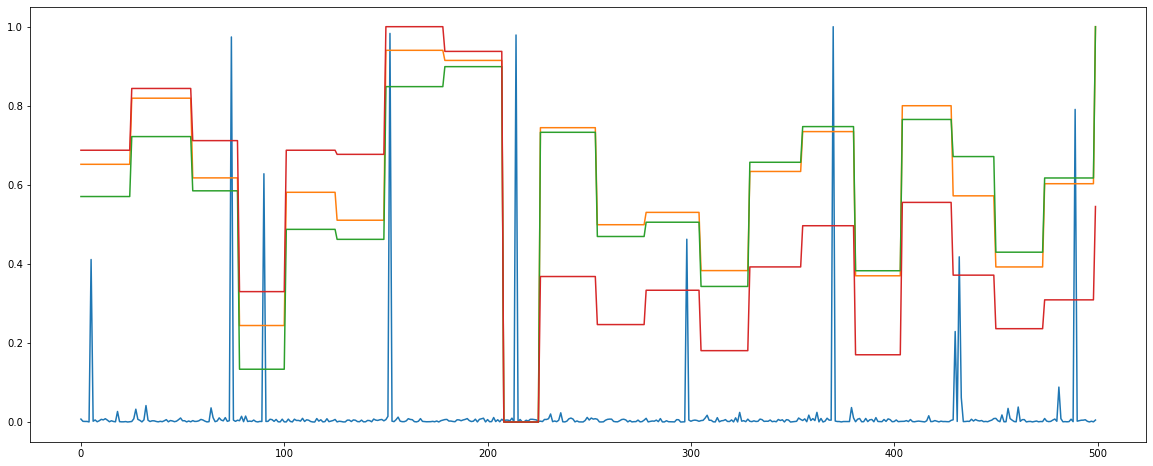

In [8]:
data_pl = data_span.loc[data_span.operation_name == "Recv.setCurrency"].iloc[:500]
plt.figure(figsize=(20, 8))
plt.plot(MinMaxScaler().fit_transform(data_pl.duration.values.reshape(len(data_pl), 1)))
plt.plot(MinMaxScaler().fit_transform(data_pl.receive_bytes.values.reshape(len(data_pl), 1)))
plt.plot(MinMaxScaler().fit_transform(data_pl.receive_packets.values.reshape(len(data_pl), 1)))
plt.plot(MinMaxScaler().fit_transform(data_pl.transmit_packets.values.reshape(len(data_pl), 1)))
plt.show()

### 3.1.Spans

In [9]:
from sklearn.ensemble import RandomForestRegressor

scaler = MinMaxScaler()
exog_columns = [c for c in data_span.columns if c not in ["duration", "step", "time", "operation_name", "start_time"]]
X, y, original_y = prepare_data(data_span.loc[data_span.operation_name == "Recv.setCurrency"], time_window=10, scaler=scaler, scale_y=False, exog_columns=exog_columns, 
            oneh_columns=[], exog_scaler=StandardScaler(), future=1, y_column="duration", exog_x_alignment=True, oneh_x_alignment=False, combine_endog_exog=True)
X = X.reshape(X.shape[0], X.shape[1])

print(X.shape)
print(y.shape)
print(original_y.shape)

train_size = int(len(X) * 0.7)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
_, original_y_test = original_y[:train_size], original_y[train_size:]

data_training = [prepare_data_for_training_last_n_fold(X_train, X_test, y_train, y_test, original_y, original_y_test)]

model = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=100,
                              min_samples_leaf=5, min_samples_split=2, n_estimators=1000,
                             n_jobs=-1, random_state=1, verbose=True)

train_scikit(data=data_training, columns=["1"], model=model, scalers=None, test_steps=1)

KeyError: 'Recv.ProductCatalogService.ListProducts'

### LSTM

c:\users\rados\appdata\local\programs\python\python37\lib\site-packages\src\data_preprocessing\utils.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[column_name] = scaler.fit_transform(x)
c:\users\rados\appdata\local\programs\python\python37\lib\site-packages\src\data_preprocessing\utils.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[column_name] = scaler.fit_transform(x)
c:\users\rados\appdata\local\programs\python\python37\lib\site-packages\src\data_preprocessing\utils.py:20: SettingW

(708, 10, 11)
(708, 1)
(708,)
Training for  all
Train on 509 samples, validate on 57 samples
Epoch 1/5
509/509 [==============================] - 18s 34ms/sample - loss: 0.0262 - val_loss: 0.0274
Epoch 2/5
509/509 [==============================] - 7s 14ms/sample - loss: 0.0253 - val_loss: 0.0280
Epoch 3/5
509/509 [==============================] - 7s 14ms/sample - loss: 0.0251 - val_loss: 0.0280
Epoch 4/5
509/509 [==============================] - 7s 14ms/sample - loss: 0.0245 - val_loss: 0.0280
Epoch 5/5
509/509 [==============================] - 7s 14ms/sample - loss: 0.0250 - val_loss: 0.0283
Execution time  46.0462384223938


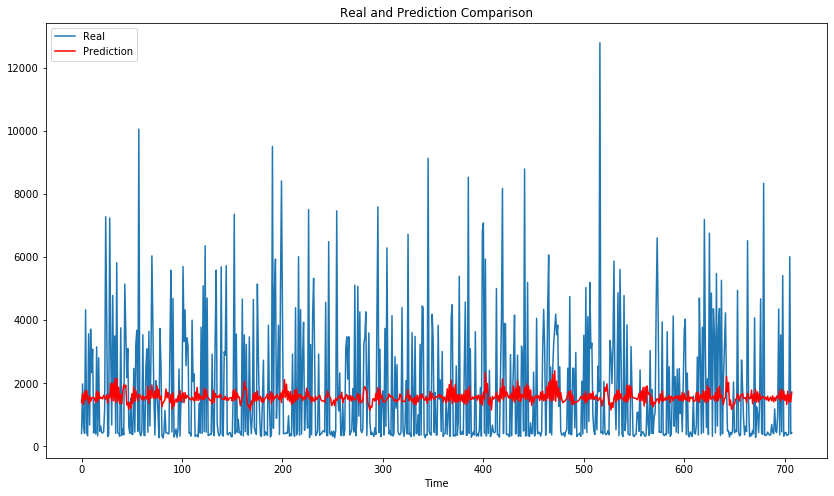

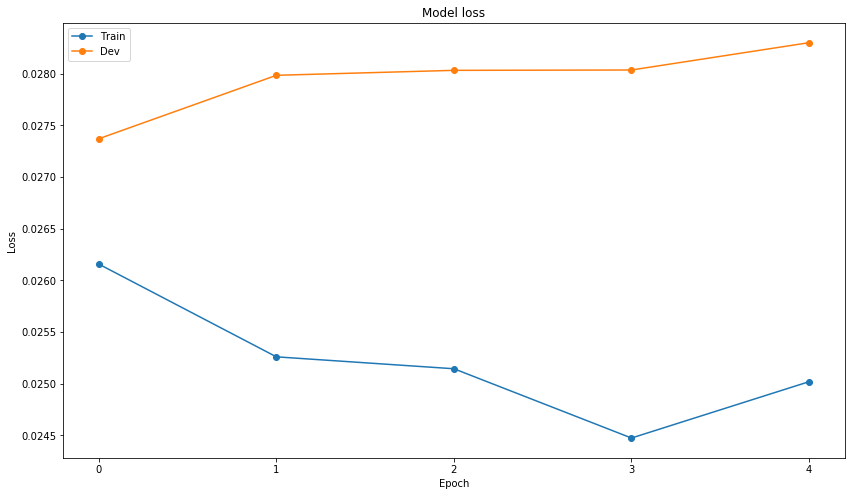

Final RMSE:  1945.7808040501843
Final Test RMSE:  1841.604144361988
Final R2:  0.011058314488043952
Final Test R2:  -0.0014069673142602657


In [18]:
exog_columns = [c for c in data_metrics.columns if c not in ["duration", "step", "time", "operation_name", "start_time"]]
time_window = 10

scaler = MinMaxScaler()
X, y, original_y = prepare_data(data_span.loc[data_span.operation_name == "Recv.setCurrency"], time_window=time_window, scaler=scaler, scale_y=True, exog_columns=exog_columns, 
            oneh_columns=[], exog_scaler=StandardScaler(), future=1, y_column="duration", exog_x_alignment=True, oneh_x_alignment=False, combine_endog_exog=True)
X = X.reshape(X.shape[0], time_window, int(X.shape[1] / time_window))

print(X.shape)
print(y.shape)
print(original_y.shape)


train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
_, original_y_test = original_y[:train_size], original_y[train_size:]

data_training = [prepare_data_for_training_last_n_fold(X_train, X_test, y_train, y_test,
                                                       original_y, original_y_test)]
lstm = create_rnn_net(time_window, len(exog_columns) + 1, rnn_type="LSTM", layers_size=[16, 16], dropout=0.1)

train_nn(data_training,
             ["all"],
             [],
             0.1,
             [scaler],
             "adam",
             2,
             lstm,
             epochs=5,
             test_steps=1,
             verbose=True,
             loss="mean_squared_error",
             save_results=False,
             results_output="out/",
             use_exog=False,
             label_data=None)

### 3.2. Metrics

### Random Forrest

In [13]:
scaler = MinMaxScaler()
exog_columns = [c for c in data_metrics.columns if c not in ["receive_bytes", "step", "time", "operation_name", "start_time"]]

X, y, original_y = prepare_data(data_metrics, time_window=5, scaler=scaler, scale_y=True, exog_columns=exog_columns, 
            oneh_columns=[], exog_scaler=StandardScaler(), future=1, y_column="receive_bytes", exog_x_alignment=True, oneh_x_alignment=False, combine_endog_exog=True)
X = X.reshape(X.shape[0], X.shape[1])

print(X.shape)
print(y.shape)
print(original_y.shape)

train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
_, original_y_test = original_y[:train_size], original_y[train_size:]

data_training = [prepare_data_for_training_last_n_fold(X_train, X_test, y_train, y_test, original_y, original_y_test)]

(713, 100)
(713, 1)
(713,)


c:\users\rados\appdata\local\programs\python\python37\lib\site-packages\src\data_preprocessing\utils.py:13: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  return np.hstack(a[i:i-width+1 or None:stepsize] for i in range(0, width))


Training for  1
Execution time  0.11924862861633301


c:\users\rados\appdata\local\programs\python\python37\lib\site-packages\performance_anomaly_detection\training\time_series_training.py:41: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_s, y_train_s)
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    0.0s finished


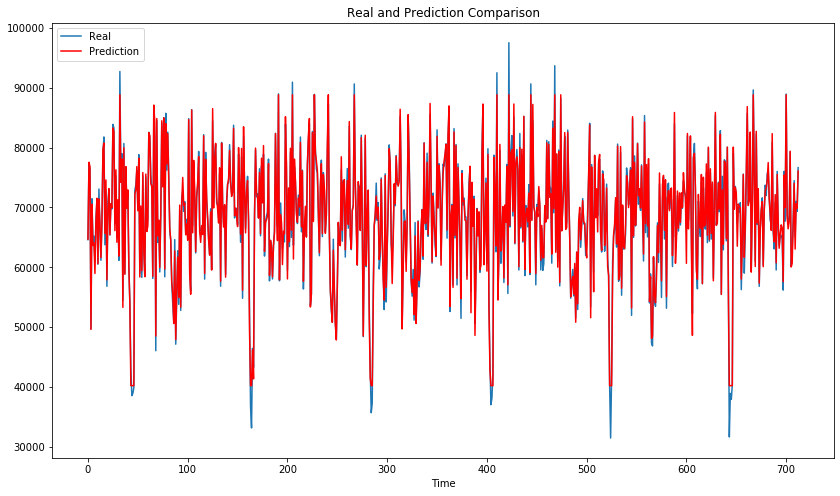

Final RMSE:  1327.173154234414
Final Test RMSE:  1566.7168504295912
Final R2:  0.9829621569685376
Final Test R2:  0.9698952864029913


In [15]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=50,
                              min_samples_leaf=10, min_samples_split=2, n_estimators=20,
                             n_jobs=-1, random_state=1, verbose=True)

train_scikit(data=data_training, columns=["1"], model=model, scalers=[scaler], test_steps=1)

### FilterNet

In [16]:
exog_columns = [c for c in data_metrics.columns if c not in ["receive_bytes", "step", "time", "operation_name", "start_time"]]

scaler = MinMaxScaler()
X, y, original_y, exog = prepare_data(data_metrics, time_window=10, scaler=scaler, scale_y=True, exog_columns=exog_columns, 
            oneh_columns=[], exog_scaler=StandardScaler(), future=1, y_column="receive_bytes", exog_x_alignment=True, oneh_x_alignment=False, combine_endog_exog=False)

print(X.shape)
print(y.shape)
print(original_y.shape)
print(exog.shape)

train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
exog_train, exog_test = exog[:train_size], exog[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
_, original_y_test = original_y[:train_size], original_y[train_size:]

data_training = [prepare_data_for_training_last_n_fold(X_train, X_test, y_train, y_test,
                                                       original_y, original_y_test, exog_train, exog_test)]

(708, 10, 1)
(708, 1)
(708,)
(708, 190)


c:\users\rados\appdata\local\programs\python\python37\lib\site-packages\src\data_preprocessing\utils.py:13: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  return np.hstack(a[i:i-width+1 or None:stepsize] for i in range(0, width))


Training for  all
Train on 537 samples, validate on 29 samples
Epoch 1/5
537/537 [==============================] - 4s 8ms/sample - loss: 0.1112 - val_loss: 0.0255
Epoch 2/5
537/537 [==============================] - 2s 3ms/sample - loss: 0.0366 - val_loss: 0.0175
Epoch 3/5
537/537 [==============================] - 2s 3ms/sample - loss: 0.0091 - val_loss: 0.0098
Epoch 4/5
537/537 [==============================] - 2s 4ms/sample - loss: 0.0032 - val_loss: 0.0096
Epoch 5/5
537/537 [==============================] - 2s 3ms/sample - loss: 0.0019 - val_loss: 0.0078
Execution time  12.14028286933899


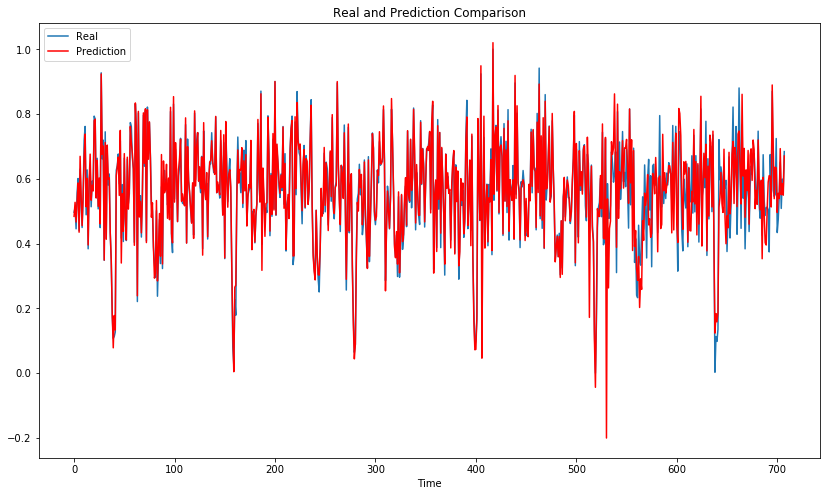

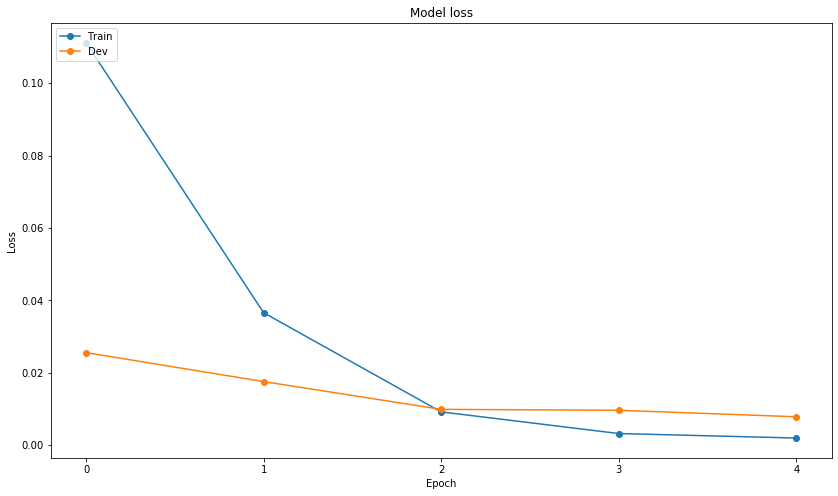

Final RMSE:  0.05236273335717506
Final Test RMSE:  0.07830555671038754
Final R2:  0.8843966884699639
Final Test R2:  0.6724217750065176


In [18]:
filter_net = create_filter_net(time_series_len=10, exog_input_size=190, layer_one_size=6, layer_two_size=4,
                    exog_layer_sizes=[2**8, 2**7], dropout=0.)

train_nn(data_training,
             ["all"],
             [],
             0.05,
             [scaler],
             "adam",
             2,
             filter_net,
             epochs=5,
             test_steps=1,
             verbose=True,
             loss="mean_squared_error",
             save_results=False,
             results_output="out/",
             use_exog=True,
             label_data=None)

### LSTM

In [10]:
exog_columns = [c for c in data_metrics.columns if c not in ["receive_bytes", "step", "time", "operation_name", "start_time"]]
time_window = 10
scaler = MinMaxScaler()
X, y, original_y = prepare_data(data_metrics, time_window=time_window, scaler=scaler, scale_y=True, exog_columns=exog_columns, 
            oneh_columns=[], exog_scaler=StandardScaler(), future=1, y_column="receive_bytes", exog_x_alignment=True, oneh_x_alignment=False, combine_endog_exog=True)
X = X.reshape(X.shape[0], time_window, int(X.shape[1] / time_window))

print(X.shape)
print(y.shape)
print(original_y.shape)


train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
_, original_y_test = original_y[:train_size], original_y[train_size:]

data_training = [prepare_data_for_training_last_n_fold(X_train, X_test, y_train, y_test,
                                                       original_y, original_y_test)]

(708, 10, 20)
(708, 1)
(708,)


c:\users\rados\appdata\local\programs\python\python37\lib\site-packages\src\data_preprocessing\utils.py:13: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  return np.hstack(a[i:i-width+1 or None:stepsize] for i in range(0, width))


Training for  all
Train on 509 samples, validate on 57 samples
Epoch 1/5
509/509 [==============================] - 16s 32ms/sample - loss: 0.0452 - val_loss: 0.0260
Epoch 2/5
509/509 [==============================] - 7s 13ms/sample - loss: 0.0256 - val_loss: 0.0212
Epoch 3/5
509/509 [==============================] - 7s 13ms/sample - loss: 0.0212 - val_loss: 0.0170
Epoch 4/5
509/509 [==============================] - 6s 13ms/sample - loss: 0.0152 - val_loss: 0.0130
Epoch 5/5
509/509 [==============================] - 7s 13ms/sample - loss: 0.0134 - val_loss: 0.0120
Execution time  42.79696822166443


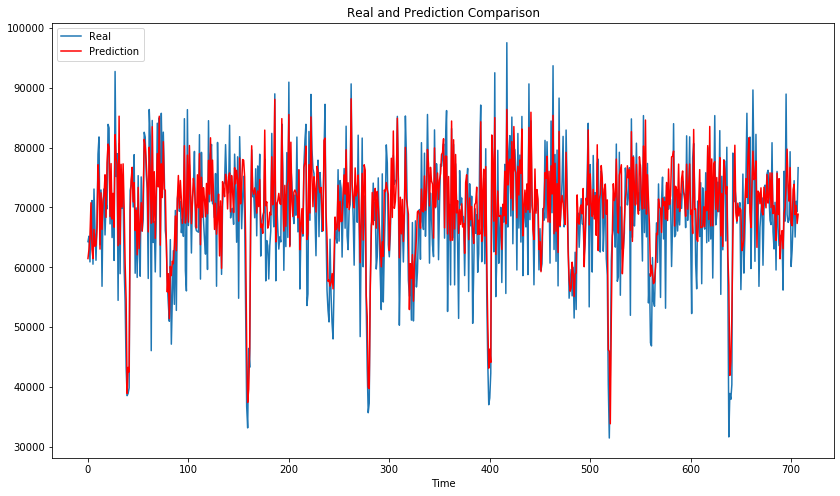

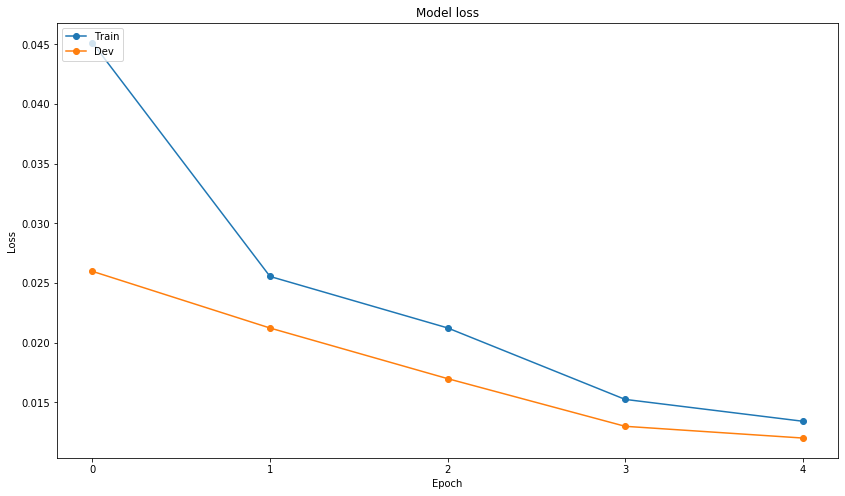

Final RMSE:  5916.86176613194
Final Test RMSE:  6897.833595034578
Final R2:  0.661375797673905
Final Test R2:  0.4168708120686625


In [11]:
lstm = create_rnn_net(time_window, 20, rnn_type="LSTM", layers_size=[32, 32], dropout=0.2)

train_nn(data_training,
             ["all"],
             [],
             0.1,
             [scaler],
             "adam",
             2,
             lstm,
             epochs=5,
             test_steps=1,
             verbose=True,
             loss="mean_squared_error",
             save_results=False,
             results_output="out/",
             use_exog=False,
             label_data=None)

## 3.3. Traces

### Random Forrest

In [15]:
scaler = MinMaxScaler()
exog_columns = [c for c in data_traces.columns if c not in ["trace_duration", "Recv.grpc.health.v1.Health.Check", "Recv.", "step", "time", "trace_id", "start_time", "end_time"]]

X, y, original_y = prepare_data(data_traces, time_window=5, scaler=scaler, scale_y=True, exog_columns=exog_columns, 
            oneh_columns=[], exog_scaler=StandardScaler(), future=1, y_column="trace_duration", exog_x_alignment=True, oneh_x_alignment=False, combine_endog_exog=True)
X = X.reshape(X.shape[0], X.shape[1])

print(X.shape)
print(y.shape)
print(original_y.shape)

train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
_, original_y_test = original_y[:train_size], original_y[train_size:]

data_training = [prepare_data_for_training_last_n_fold(X_train, X_test, y_train, y_test, original_y, original_y_test)]

(39685, 95)
(39685, 1)
(39685,)


c:\users\rados\appdata\local\programs\python\python37\lib\site-packages\src\data_preprocessing\utils.py:13: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  return np.hstack(a[i:i-width+1 or None:stepsize] for i in range(0, width))


Training for  1


c:\users\rados\appdata\local\programs\python\python37\lib\site-packages\performance_anomaly_detection\training\time_series_training.py:41: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_s, y_train_s)
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    5.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    0.0s finished


Execution time  5.662519931793213


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    0.0s finished


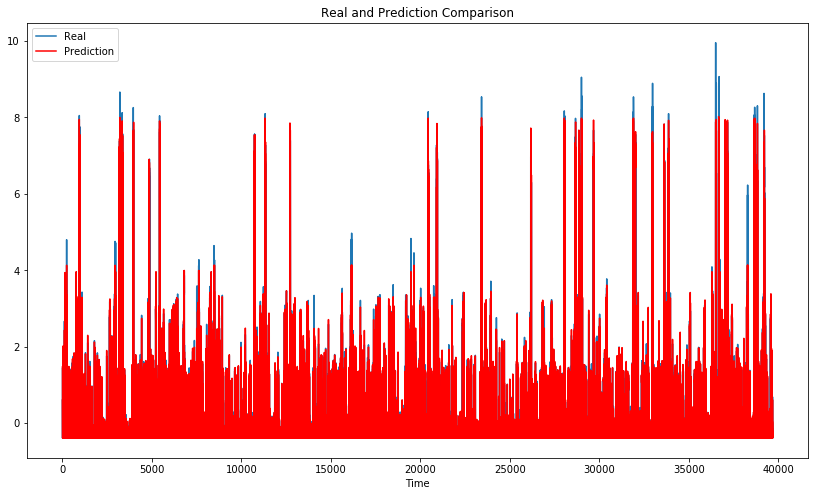

Final RMSE:  0.04940535776584403
Final Test RMSE:  0.08290053899424922
Final R2:  0.9975592342529038
Final Test R2:  0.9958554028167644


In [16]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
                              min_samples_leaf=10, min_samples_split=2, n_estimators=20,
                             n_jobs=-1, random_state=1, verbose=True)

train_scikit(data=data_training, columns=["1"], model=model, scalers=[scaler], test_steps=1)

### FilterNet

In [17]:
exog_columns = [c for c in data_traces.columns if c not in ["trace_duration", "Recv.grpc.health.v1.Health.Check", "Recv.", "step", "time", "trace_id", "start_time", "end_time"]]

scaler = MinMaxScaler()
X, y, original_y, exog = prepare_data(data_traces, time_window=10, scaler=scaler, scale_y=True, exog_columns=exog_columns, 
            oneh_columns=[], exog_scaler=StandardScaler(), future=1, y_column="trace_duration", exog_x_alignment=True, oneh_x_alignment=False, combine_endog_exog=False)

print(X.shape)
print(y.shape)
print(original_y.shape)
print(exog.shape)

train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
exog_train, exog_test = exog[:train_size], exog[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
_, original_y_test = original_y[:train_size], original_y[train_size:]

data_training = [prepare_data_for_training_last_n_fold(X_train, X_test, y_train, y_test,
                                                       original_y, original_y_test, exog_train, exog_test)]

(39680, 10, 1)
(39680, 1)
(39680,)
(39680, 180)


c:\users\rados\appdata\local\programs\python\python37\lib\site-packages\src\data_preprocessing\utils.py:13: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  return np.hstack(a[i:i-width+1 or None:stepsize] for i in range(0, width))


In [19]:
exog_columns

['Recv.ProductCatalogService.ListProducts',
 'Recv._healthz',
 'Recv.setCurrency',
 'Sent.AdService.GetAds',
 'Sent.CartService.GetCart',
 'Sent.CurrencyService.Convert',
 'Sent.CurrencyService.GetSupportedCurrencies',
 'Sent.ProductCatalogService.ListProducts',
 'receive_packets',
 'receive_packets_dropped',
 'transmit_packets',
 'transmit_packets_dropped',
 'receive_bytes',
 'transmit_errors',
 'container_memory_usage_bytes_value',
 'container_memory_working_set_bytes_value',
 'container_cpu_system_seconds_total_value',
 'container_cpu_usage_seconds_total_value']

Training for  all
Train on 30156 samples, validate on 1588 samples
Epoch 1/5
30156/30156 [==============================] - 101s 3ms/sample - loss: 0.0100 - val_loss: 1.7203e-04
Epoch 2/5
30156/30156 [==============================] - 109s 4ms/sample - loss: 2.9923e-04 - val_loss: 1.0317e-04
Epoch 3/5
30156/30156 [==============================] - 112s 4ms/sample - loss: 2.1989e-04 - val_loss: 5.4814e-05
Epoch 4/5
30156/30156 [==============================] - 110s 4ms/sample - loss: 1.8942e-04 - val_loss: 1.5846e-04
Epoch 5/5
30156/30156 [==============================] - 105s 3ms/sample - loss: 1.6661e-04 - val_loss: 5.4054e-05
Execution time  536.4795680046082


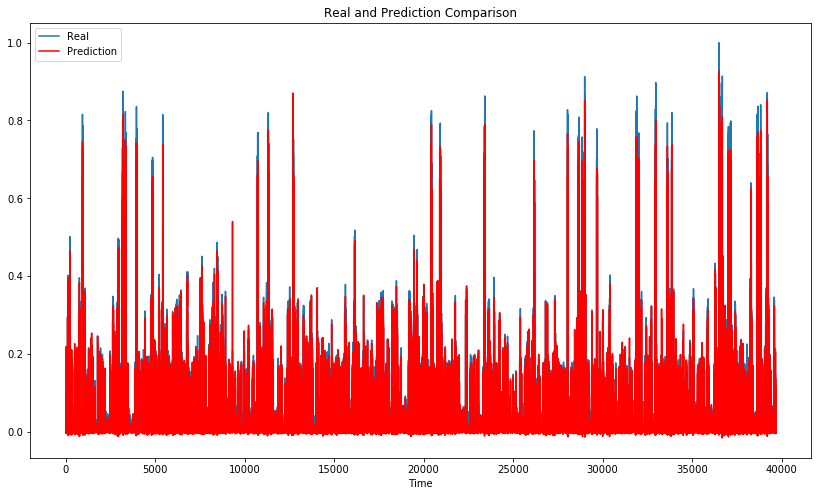

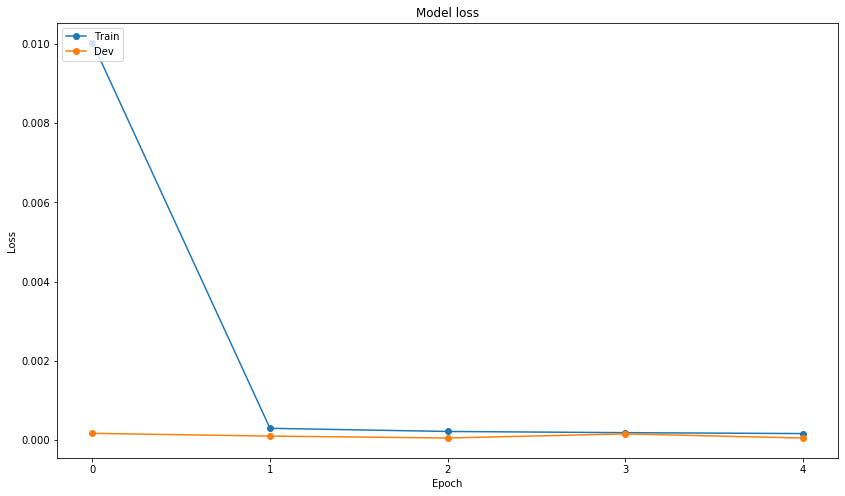

Final RMSE:  0.011833865787015892
Final Test RMSE:  0.015013023198802494
Final R2:  0.9850264314333356
Final Test R2:  0.9854663886769747


In [18]:
filter_net = create_filter_net(time_series_len=10, exog_input_size=180, layer_one_size=6, layer_two_size=4,
                    exog_layer_sizes=[2**8, 2**7], dropout=0.)

train_nn(data_training,
             ["all"],
             [],
             0.05,
             [scaler],
             "adam",
             2,
             filter_net,
             epochs=5,
             test_steps=1,
             verbose=True,
             loss="mean_squared_error",
             save_results=False,
             results_output="out/",
             use_exog=True,
             label_data=None)

### LSTM

In [46]:
exog_columns = [c for c in data_traces.columns if c not in ["step", "time", "trace_id", "start_time", "end_time"]]
time_window = 10
scaler = MinMaxScaler()
X, y, original_y = prepare_data(data_traces, time_window=time_window, scaler=scaler, scale_y=True, exog_columns=exog_columns, 
            oneh_columns=[], exog_scaler=StandardScaler(), future=1, y_column="trace_duration", exog_x_alignment=True, oneh_x_alignment=False, combine_endog_exog=True)
X = X.reshape(X.shape[0], time_window, int(X.shape[1] / time_window))

print(X.shape)
print(y.shape)
print(original_y.shape)


train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
_, original_y_test = original_y[:train_size], original_y[train_size:]

data_training = [prepare_data_for_training_last_n_fold(X_train, X_test, y_train, y_test,
                                                       original_y, original_y_test)]

(39680, 10, 22)
(39680, 1)
(39680,)


c:\users\rados\appdata\local\programs\python\python37\lib\site-packages\src\data_preprocessing\utils.py:13: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  return np.hstack(a[i:i-width+1 or None:stepsize] for i in range(0, width))


Training for  all
Train on 28569 samples, validate on 3175 samples
Epoch 1/3
28569/28569 [==============================] - 363s 13ms/sample - loss: 0.0013 - val_loss: 2.3093e-04
Epoch 2/3
28569/28569 [==============================] - 363s 13ms/sample - loss: 5.1998e-04 - val_loss: 2.4391e-04
Epoch 3/3
28569/28569 [==============================] - 370s 13ms/sample - loss: 4.0606e-04 - val_loss: 1.4976e-04
Execution time  1096.0641877651215


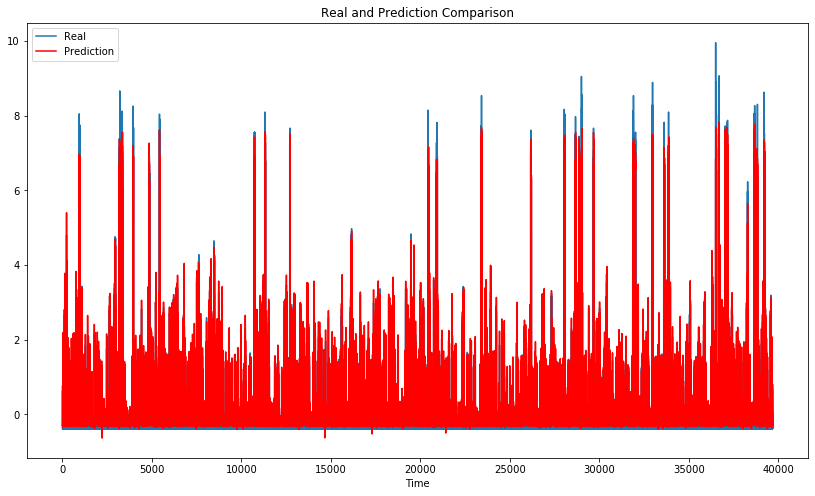

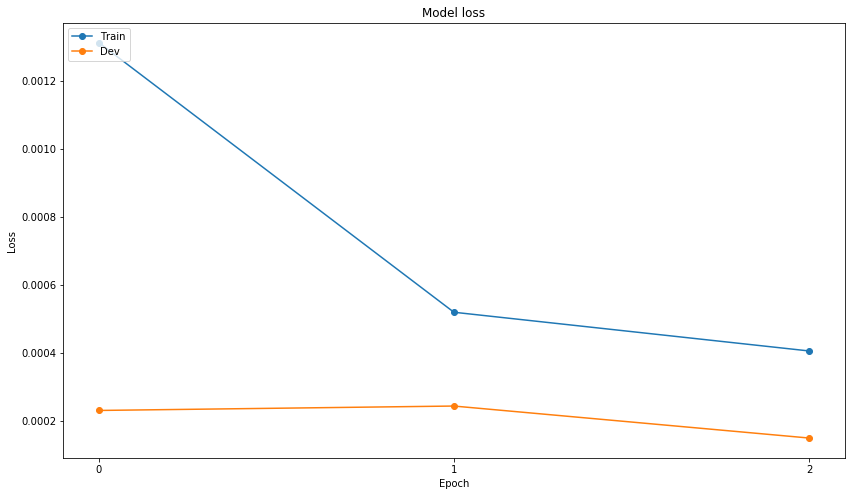

Final RMSE:  0.116729415655666
Final Test RMSE:  0.15392252265566994
Final R2:  0.986375762070415
Final Test R2:  0.9857136549624664


In [48]:
lstm = create_rnn_net(time_window, 22, rnn_type="LSTM", layers_size=[16, 16], dropout=0.2)

train_nn(data_training,
             ["all"],
             [],
             0.1,
             [scaler],
             "adam",
             2,
             lstm,
             epochs=3,
             test_steps=1,
             verbose=True,
             loss="mean_squared_error",
             save_results=False,
             results_output="out/",
             use_exog=False,
             label_data=None)

## 4. Results

In [49]:
y_hat = np.concatenate((lstm.predict(X_train), lstm.predict(X_test)), axis=0)
y = MinMaxScaler().fit_transform(original_y.reshape(len(y_hat), 1))

### 4.1. Detect Anomalies

In [50]:
gt_detector = GaussianTailDetector(window_size = 100, small_window_size = 5, e = 0.9)

gaussian_tail_anomalies = []

for i in range(len(y_hat)):
    gt_detector.add_values(y[i], y_hat[i])
    
    if gt_detector.is_anomaly():
        gaussian_tail_anomalies.append(i)

In [51]:
acc_detector = AccumulativeDetector(w=0.4, e=-0.025, p=0.35, var_window_size=50, with_var=True, diff_type=DiffType.up)

acc_anomalies = []

for i, y_val, y_hat_val in zip(range(len(y_hat)), y, y_hat):
    acc_detector.add_values(y[i], y_hat[i])
    
    if acc_detector.is_anomaly():
        acc_anomalies.append(i)

### 4.2. Anomaly points

**Gaussian Tail**

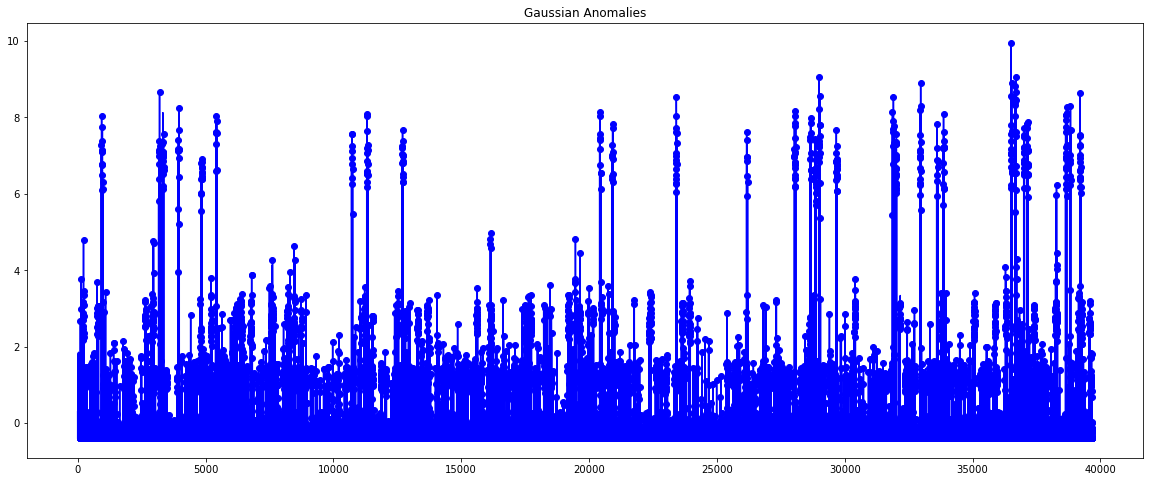

In [56]:
markers = list(np.array(gaussian_tail_anomalies).flatten())

plt.figure(figsize=(20,8))
plt.title("Gaussian Anomalies")
plt.plot(range(len(original_y)), original_y, '-bo', markevery=markers)
plt.show()

**Accumulator**

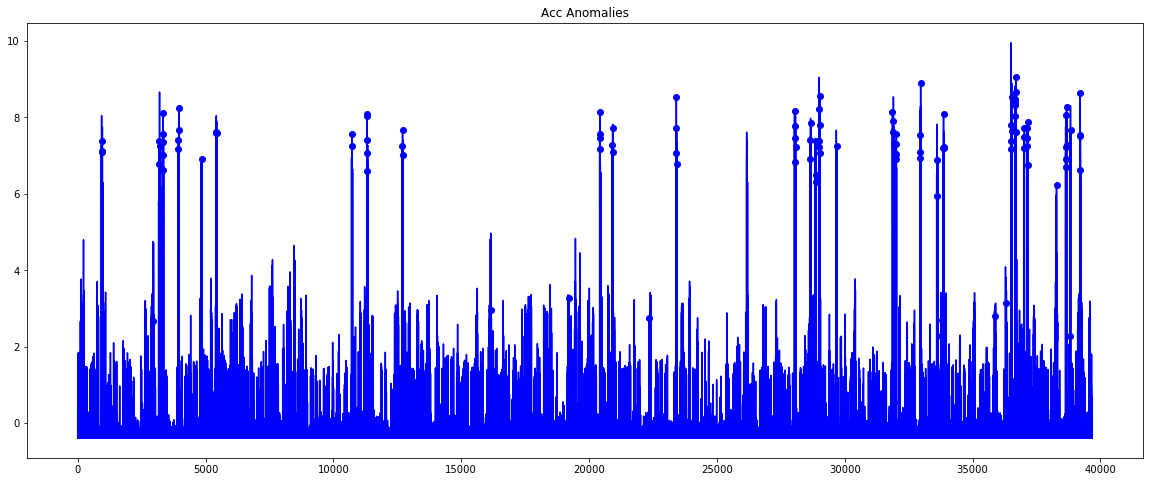

In [53]:
markers = list(np.array(acc_anomalies).flatten())

plt.figure(figsize=(20,8))
plt.title("Acc Anomalies")
plt.plot(range(len(original_y)), original_y, '-bo', markevery=markers)
plt.show()

**Intersection**

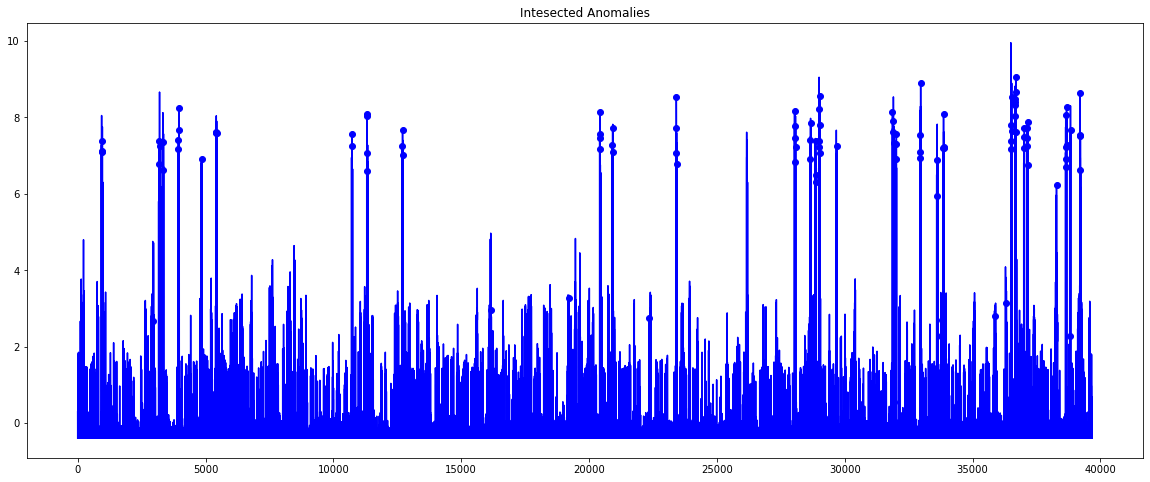

In [54]:
markers = list(np.intersect1d(acc_anomalies, gaussian_tail_anomalies).flatten())

plt.figure(figsize=(20,8))
plt.title("Intesected Anomalies")
plt.plot(range(len(original_y)), original_y, '-bo', markevery=markers)
plt.show()